In [1]:
import os


import pandas as pd
import numpy as np
# import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from cal_feature import *
from plot_transient import *
from plot_feature1 import *
from plot_feature2 import *
from myMedFilter import *
from myHeatMap import *
from myScatter import *
from linearRegression import *

In [2]:
# define local directions
file_forder = "./transient_timeDomain/" 
up_dir = "./up_edge/"
down_dir = "./down_edge/"
up_pic_dir = "./up_edge_pic/"
down_pic_dir = "./down_edge_pic/"
feature_pic_dir = "./feature_pic/"
# save flag
SAVE_TRANSIENT = True
SAVE_SAMPLE = True
# plot flag
PLOT_TRANSIENT = False
PLOT_FEATURE = True
# feature flag
PRE_SLICE = -30
DUR_SLICE = 1024
DUR_SLICE_UP = 1024
SUB_SAMPLE = 1
NUM_MEAN = 15
DROP_OUTLIERS = True
CORR_TRESH1 = 0.99
CORR_TRESH2 = 0.6
# train flag
NUM_SPLIT = 370
BATCH_SIZE = 512
NUM_HIDEN1 = 100
NUM_HIDEN2 = 32
DROPOUT = 0.5
NUM_EPOCH = 50000
# proceed flag
IS_SLICE = True
IS_EXPAND = True
IS_TRAIN = True
# debug mode
DEBUG_MODE = False

# slice data while switching 
### 1. up-edge 
### 2. down-edge

In [3]:
# slice data
if IS_SLICE:
    if DEBUG_MODE:
        SAVE_TRANSIENT = False
        PLOT_TRANSIENT = True
        PRE_SLICE = 30
        DUR_SLICE = 512

    for (_ ,_ , process_files) in os.walk(file_forder):
        for file in process_files:
            sample_df = pd.read_csv(file_forder + file )
            sample_name = file[:-4]
            # get index in up and down edge
            n = np.where(sample_df.gateSignalVoltage.values>8)  # return a tuple so use n[0][0] to index
            # slice data
            up_df = sample_df.iloc[n[0][0]-PRE_SLICE:n[0][0]+DUR_SLICE_UP-PRE_SLICE,:]
            down_df = sample_df.iloc[n[0][-1]-PRE_SLICE:n[0][-1]+DUR_SLICE_UP-PRE_SLICE,:]
            # expand feature
            up_df = up_df.drop(["collectorEmitterCurrentSingal"],axis = 1)
            up_df["P"] = up_df["gateEmitterVoltage"]*up_df["collectorEmitterVoltage"]
            down_df = down_df.drop(["collectorEmitterCurrentSingal"],axis = 1)
            down_df["P"] = down_df["gateEmitterVoltage"]*down_df["collectorEmitterVoltage"]
            # save data
            if SAVE_TRANSIENT:
                up_df.to_csv(up_dir+file,index = False)
                down_df.to_csv(down_dir+file,index = False)
            # plot data
            if PLOT_TRANSIENT:
                plot_transient(down_df,sample_name, down_pic_dir)
                plot_transient(up_df,sample_name,up_pic_dir)

    # show info
    # print(sample_df.shape)
    # print(sample_df.columns)
    # sample_df.head()

# featuring

### extract features

In [4]:
# define local directions
up_dir = "./up_edge/"
down_dir = "./down_edge/"
if DEBUG_MODE:
    SUB_SAMPLE = 8
    SAVE_SAMPLE = True
    NUM_MEAN = 20
#  down edge
all_feature_df = pd.DataFrame()
for (_ ,_ , process_files) in os.walk(file_forder):
    for file in process_files:
        # read file
        sample_df = pd.read_csv(down_dir+file)
        sample_df.fillna(method = "backfill",inplace = True)
        # calculate features
        for i in range(SUB_SAMPLE):
            subsample_df = sample_df.loc[i::SUB_SAMPLE,:]
            if SAVE_SAMPLE:
                subsample_df.to_csv(down_dir+file[0:-4]+"_"+str(i)+".csv",index = False)
            cols = sample_df.columns
            feature_df = pd.DataFrame()
            for col in cols:
                df = cal_feature(subsample_df, col)
                feature_df = pd.concat([feature_df,df],axis = 1)
            feature_df["Vce_pre"] = np.mean(sample_df['collectorEmitterVoltage'].values[:NUM_MEAN])
            feature_df["P_pre"] = np.mean(sample_df['P'].values[:NUM_MEAN])
            feature_df['round'] = int(file[0:-4])

            all_feature_df = pd.concat([all_feature_df,feature_df],axis = 0)

all_feature_df.sort_values(by = 'round', inplace=True)    
all_feature_df.to_csv('./temp/down_edge_features_subsample.csv',index = False)

# up edge
all_feature_df = pd.DataFrame()
for (_ ,_ , process_files) in os.walk(file_forder):
    for file in process_files:
        # read file
        sample_df = pd.read_csv(up_dir+file)
        sample_df.fillna(method = "backfill",inplace = True)
        # calculate features
        for i in range(SUB_SAMPLE):
            subsample_df = sample_df.loc[i::SUB_SAMPLE,:]
            if SAVE_SAMPLE:
                subsample_df.to_csv(up_dir+file[0:-4]+"_"+str(i)+".csv",index = False)
            cols = sample_df.columns
            feature_df = pd.DataFrame()
            for col in cols:
                df = cal_feature(subsample_df, col)
                feature_df = pd.concat([feature_df,df],axis = 1)
            feature_df["Vce_post"] = np.mean(sample_df['collectorEmitterVoltage'].values[-NUM_MEAN:])
            feature_df["P_post"] = np.mean(sample_df['P'].values[-NUM_MEAN:])
            feature_df['round'] = int(file[0:-4])

            all_feature_df = pd.concat([all_feature_df,feature_df],axis = 0)

all_feature_df.sort_values(by = 'round', inplace=True)    
all_feature_df.to_csv('./temp/up_edge_features_subsample.csv',index = False)

print(all_feature_df.shape)
all_feature_df.head()

(418, 107)


,gateSignalVoltage_min,gateSignalVoltage_max,gateSignalVoltage_range,gateSignalVoltage_mean,gateSignalVoltage_mode,gateSignalVoltage_median,gateSignalVoltage_quantile25,gateSignalVoltage_quantile75,gateSignalVoltage_std,gateSignalVoltage_var,...,P_sf,P_MI,P_CF,P_llr,P_pi,P_sdif,P_cpt1,Vce_post,P_post,round
0,9.609375,10.546875,0.937500,10.002671,10.0,10.0,9.921875,10.078125,0.096716,0.009354,...,1.003513,0.344941,0.343098,3.733735,1.093844,0.083935,1.095869,3.191667,31.600913,1
0,9.531250,10.312500,0.781250,9.997254,10.0,10.0,9.921875,10.078125,0.088229,0.007784,...,1.004094,0.453329,0.450505,4.853263,1.176929,0.090628,1.179479,2.062500,20.401200,2
0,9.453125,10.234375,0.781250,9.985199,10.0,10.0,9.921875,10.000000,0.096945,0.009398,...,1.007754,0.578294,0.571392,3.219602,1.213801,0.124829,1.219011,2.010416,19.947099,3
0,9.296875,10.312500,1.015625,9.998398,10.0,10.0,9.921875,10.078125,0.113010,0.012771,...,1.011730,0.674795,0.662483,2.683325,1.231819,0.153693,1.240163,2.052083,20.402828,4
0,9.296875,10.234375,0.937500,9.981079,10.0,10.0,9.921875,10.000000,0.116067,0.013472,...,1.014431,0.633546,0.619197,2.435038,1.169282,0.170583,1.179360,2.166667,21.508792,5


### conband the up and down features

In [5]:
# conband the up and down features
up_df = pd.read_csv('./temp/up_edge_features_subsample.csv')
down_df = pd.read_csv('./temp/down_edge_features_subsample.csv')
# rename cosls
up_cols = ['up_'+c for c in up_df.columns]
down_cols = ['down_'+c for c in down_df.columns]
up_df.columns = up_cols
down_df.columns = down_cols
up_df.rename(columns={"up_round":"round"},inplace = True)
down_df.rename(columns={"down_round":"round"},inplace = True)
# merge
train_df = pd.merge(up_df,down_df, how="left",on = "round" )
# save
train_df.to_csv("./temp/train_feature_df_subsample.csv",index = False)
print(train_df.shape)
train_df.head()

(418, 213)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_I,down_P_sf,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre
0,9.609375,10.546875,0.937500,10.002671,10.0,10.0,9.921875,10.078125,0.096716,0.009354,...,9.276831,2.620945,45.344777,3.800096,0.238768,9.396837,2.429093,42.235185,4.950000,40.146485
1,9.531250,10.312500,0.781250,9.997254,10.0,10.0,9.921875,10.078125,0.088229,0.007784,...,8.872677,2.179372,18.055420,4.217589,0.468781,11.587297,2.041421,17.428767,2.260416,17.751462
2,9.453125,10.234375,0.781250,9.985199,10.0,10.0,9.921875,10.000000,0.096945,0.009398,...,8.121302,2.136030,16.691024,3.959639,0.469568,10.513634,1.992440,16.026756,2.156250,16.918942
3,9.296875,10.312500,1.015625,9.998398,10.0,10.0,9.921875,10.078125,0.113010,0.012771,...,7.367575,2.094107,14.887974,3.667501,0.476810,9.558501,1.948044,14.282068,2.166666,16.968584
4,9.296875,10.234375,0.937500,9.981079,10.0,10.0,9.921875,10.000000,0.116067,0.013472,...,6.940816,2.047149,13.539465,3.537891,0.492422,9.228277,1.904907,12.975320,2.241667,17.503583


### add temperature 

In [6]:
# add temperature
train_df = pd.read_csv('./temp/train_feature_df_subsample.csv')
tempareture_df = pd.read_csv("collectorEmitterVoltage_peak_temperature.csv")
train_df = pd.merge(train_df,tempareture_df, how="left",on = "round" )
# change the target num
train_df.rename(columns={"round":"num_cycle"},inplace = True)
# save
train_df.to_csv("./temp/train_feature_df_subsample.csv",index = False)

print(train_df.shape)
train_df.head()

(418, 215)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre,collectorEmitterVoltage_peak,temperature
0,9.609375,10.546875,0.937500,10.002671,10.0,10.0,9.921875,10.078125,0.096716,0.009354,...,45.344777,3.800096,0.238768,9.396837,2.429093,42.235185,4.950000,40.146485,11.937499,47.211104
1,9.531250,10.312500,0.781250,9.997254,10.0,10.0,9.921875,10.078125,0.088229,0.007784,...,18.055420,4.217589,0.468781,11.587297,2.041421,17.428767,2.260416,17.751462,25.468751,124.804264
2,9.453125,10.234375,0.781250,9.985199,10.0,10.0,9.921875,10.000000,0.096945,0.009398,...,16.691024,3.959639,0.469568,10.513634,1.992440,16.026756,2.156250,16.918942,21.250001,178.408544
3,9.296875,10.312500,1.015625,9.998398,10.0,10.0,9.921875,10.078125,0.113010,0.012771,...,14.887974,3.667501,0.476810,9.558501,1.948044,14.282068,2.166666,16.968584,18.593751,215.428544
4,9.296875,10.234375,0.937500,9.981079,10.0,10.0,9.921875,10.000000,0.116067,0.013472,...,13.539465,3.537891,0.492422,9.228277,1.904907,12.975320,2.241667,17.503583,11.937499,244.451166


# drop outliers

In [7]:
if DEBUG_MODE:
    PLOT_FEATURE = False
    DROP_OUTLIERS = True
# drop outl
round_num_del = [1,2,3,4,5,6,7,8,9,10,11,12,13,24,35,46,112,223,334,386,375,364,
                 56,153,208,309,327,347,351,360,365,391
                ]

train_df = pd.read_csv('./temp/train_feature_df_subsample.csv')
if DROP_OUTLIERS:
    for num in round_num_del:
        train_df = train_df.loc[train_df['num_cycle'].values != num,:]
try:
    train_df = train_df.loc[train_df['temperature']>326,:]
except:
    train_df.rename(columns={"tempareture":"temperature"},inplace = True)
    train_df = train_df.loc[train_df['temperature']>326,:]
if PLOT_FEATURE:
    plot_feature1(train_df,"num_cycle",feature_pic_dir)
train_df.to_csv("./temp/train_feature_df_outliers_subsample.csv",index = False)

# show info
print(train_df.shape)
train_df.head()

(383, 215)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre,collectorEmitterVoltage_peak,temperature
16,9.062500,10.234375,1.171875,9.993134,10.0,10.0,9.921875,10.078125,0.129529,0.016778,...,10.618745,3.036851,0.514079,7.389431,1.784587,10.042534,1.950000,15.047202,9.937499,329.912613
17,9.140625,10.234375,1.093750,9.987259,10.0,10.0,9.921875,10.078125,0.123097,0.015153,...,10.487646,3.071088,0.522320,7.637582,1.784489,9.925090,1.929167,14.961591,10.249999,327.237079
18,9.218750,10.312500,1.093750,9.982300,10.0,10.0,9.921875,10.078125,0.119149,0.014196,...,11.456490,3.130552,0.500065,7.748313,1.830931,10.782181,2.012500,15.580731,11.187499,326.213509
19,9.062500,10.312500,1.250000,9.976578,10.0,10.0,9.921875,10.078125,0.136195,0.018549,...,10.706815,3.125698,0.521452,7.734736,1.787730,10.048657,1.975000,15.294273,9.999999,329.365197
20,9.218750,10.312500,1.093750,9.988938,10.0,10.0,9.921875,10.078125,0.122532,0.015014,...,10.932305,3.142366,0.515953,7.777323,1.799852,10.276031,1.970834,15.385419,10.374999,328.195866


## filter

In [8]:
if DEBUG_MODE:
    PLOT_FEATURE = True
# filter
if False:
    train_df = pd.read_csv('./temp/train_feature_df_outliers.csv')
    train_df = pd.read_csv('./temp/train_feature_df.csv')
    train_df.drop(round_num_del,axis = 0,inplace = True)
    cols = [c for c in train_df.columns if c!="num_cycle"]
    for c in cols:
        train_df[c] = myMedFilter(train_df[c].values)
    if PLOT_FEATURE:
        plot_feature2(train_df,"num_cycle",feature_pic_dir)
    train_df.to_csv("./temp/train_feature_df_outliers_filter.csv",index = False)

    # show info
    print(train_df.shape)
    train_df.head()

# correlation

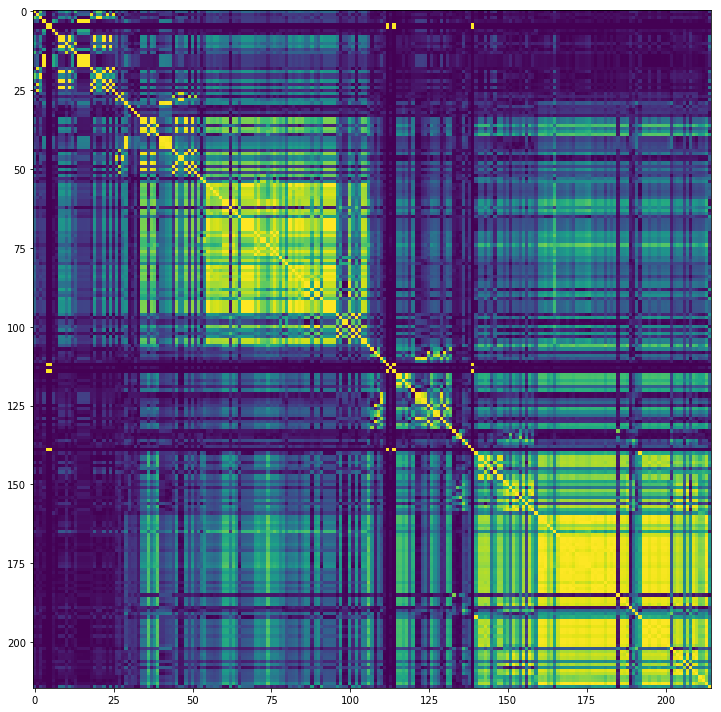

In [9]:
# train_df = pd.read_csv('./temp/train_feature_df.csv')
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
# train_df = pd.read_csv('./temp/train_feature_df_outliers_filter.csv')
corr_df = train_df.corr().abs()
corr_df.to_csv("temp/coelationship_outliners.csv")
# plot
im =np.abs(corr_df.values) 
plt.figure(figsize = (10,10))
plt.imshow(im)
plt.tight_layout()
plt.savefig('temp/correlationship'+'.png')


# feature select

In [10]:
if DEBUG_MODE:
    CORR_TRESH1 = 0.99
    CORR_TRESH2 = 0.6
# calculate corr
# train_df = pd.read_csv('./temp/train_feature_df.csv')
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
# train_df = pd.read_csv('./temp/train_feature_df_outliers_filter.csv')
corr_df = train_df.corr().abs()

# collect the duplicate cols
cols = train_df.columns.values
del_cols = []
for i in range(cols.size):
    for j in range(i+1,cols.size,1):
        if(corr_df.iloc[i,j]>CORR_TRESH1):
            if(cols[j] not in del_cols):
                del_cols.append(cols[j])
print("length of delete cols:",len(del_cols))

train_df.drop(del_cols,axis = 1,inplace= True)
corr_df = train_df.corr().abs()
corr_df.sort_values(by = 'num_cycle',axis = 0, ascending=False, inplace = True)
l = corr_df.index.to_series()
x = corr_df.loc[:,'num_cycle']>CORR_TRESH2
cols = l[x].values
print("feature length:",len(cols)-1)
print(cols)
corr_df.head()

length of delete cols: 92
feature length: 20
['num_cycle' 'down_collectorEmitterVoltage_llr' 'down_P_mean'
 'down_collectorEmitterVoltage_mean' 'down_gateEmitterVoltage_msv'
 'down_collectorEmitterVoltage_max' 'up_collectorEmitterVoltage_llr'
 'down_P_max' 'down_gateEmitterVoltage_std' 'down_gateEmitterVoltage_sdif'
 'down_gateEmitterVoltage_sf' 'down_collectorEmitterVoltage_median'
 'down_P_MI' 'up_collectorEmitterVoltage_std' 'down_P_skew'
 'down_collectorEmitterVoltage_mode'
 'down_collectorEmitterVoltage_quantile75' 'down_P_I'
 'up_gateEmitterVoltage_mad' 'down_gateEmitterVoltage_sra'
 'up_collectorEmitterVoltage_sf']


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_skew,up_gateSignalVoltage_mad,...,down_P_quantile25,down_P_skew,down_P_sra,down_P_I,down_P_MI,down_P_CF,down_P_pi,down_Vce_pre,down_P_pre,temperature
num_cycle,0.132906,0.051916,0.077054,0.078923,4.534387e-15,0.023692,0.030922,0.269739,0.244251,0.111910,...,0.246764,0.651899,0.123271,0.626944,0.674135,0.253452,0.193799,0.476584,0.530092,0.170949
down_collectorEmitterVoltage_llr,0.035589,0.016615,0.039915,0.003067,5.348097e-15,0.035041,0.021067,0.030795,0.044818,0.038892,...,0.432284,0.932152,0.252631,0.844801,0.867111,0.447787,0.464800,0.720508,0.748421,0.565786
down_P_mean,0.030136,0.023594,0.039817,0.007367,1.004273e-14,0.037261,0.024834,0.017036,0.098021,0.019127,...,0.306492,0.903019,0.045445,0.877208,0.943612,0.411383,0.318477,0.763106,0.804843,0.485241
down_collectorEmitterVoltage_mean,0.041300,0.049440,0.002900,0.038108,2.887357e-14,0.022601,0.005419,0.080612,0.127462,0.028339,...,0.560994,0.943242,0.293923,0.843520,0.878770,0.482259,0.503675,0.824353,0.834685,0.445149
down_gateEmitterVoltage_msv,0.002909,0.007693,0.002457,0.021995,7.872568e-14,0.070952,0.010628,0.055228,0.139876,0.021506,...,0.276398,0.761803,0.112306,0.746328,0.804990,0.337576,0.242265,0.600409,0.721058,0.405004


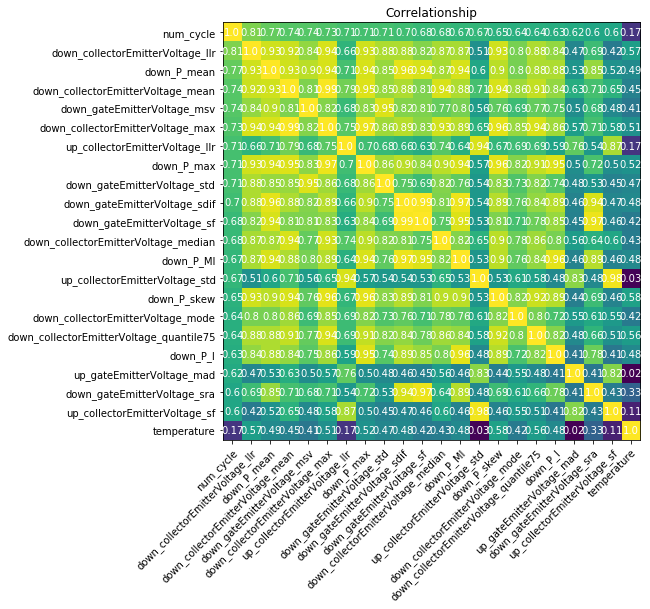

In [11]:
from myHeatMap import *
if 'temperature' not in cols:
    cols = np.append(cols,'temperature')

# train_df = pd.read_csv('./temp/train_feature_df.csv')
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
# train_df = pd.read_csv('./temp/train_df_scale.csv')
feature_df = train_df.loc[:,cols]
feature_df.to_csv('./temp/useful_feature_df.csv',index = False)
corr_df = feature_df.corr().abs()
corr_df.to_csv("temp/correlationship_usefue_features.csv")
# plot
im =np.abs(corr_df.values) 
im = im.round(2)
myHeatMap(im,cols,cols)

### scale to [0, 1]

In [12]:
# std
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
print(train_df.shape)
# drop_duplicates
train_df.drop_duplicates(subset = ['num_cycle','down_collectorEmitterVoltage_llr','up_collectorEmitterVoltage_llr'],inplace = True)
target = ["temperature","num_cycle"]
cols_to_use = [c for c in cols if c not in target]
for col in cols_to_use:
    ma = train_df[col].max()
    mi = train_df[col].min()
    train_df[col] = (train_df[col]-mi)/(ma-mi)
    
train_df.to_csv("temp/train_df_scale_subsample.csv",index = False)
print(train_df.shape)
train_df.head()

(383, 215)
(383, 215)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre,collectorEmitterVoltage_peak,temperature
0,9.062500,10.234375,1.171875,9.993134,10.0,10.0,9.921875,10.078125,0.129529,0.016778,...,0.410013,3.036851,0.514079,7.389431,1.784587,10.042534,1.950000,15.047202,9.937499,329.912613
1,9.140625,10.234375,1.093750,9.987259,10.0,10.0,9.921875,10.078125,0.123097,0.015153,...,0.371179,3.071088,0.522320,7.637582,1.784489,9.925090,1.929167,14.961591,10.249999,327.237079
2,9.218750,10.312500,1.093750,9.982300,10.0,10.0,9.921875,10.078125,0.119149,0.014196,...,0.658167,3.130552,0.500065,7.748313,1.830931,10.782181,2.012500,15.580731,11.187499,326.213509
3,9.062500,10.312500,1.250000,9.976578,10.0,10.0,9.921875,10.078125,0.136195,0.018549,...,0.436100,3.125698,0.521452,7.734736,1.787730,10.048657,1.975000,15.294273,9.999999,329.365197
4,9.218750,10.312500,1.093750,9.988938,10.0,10.0,9.921875,10.078125,0.122532,0.015014,...,0.502894,3.142366,0.515953,7.777323,1.799852,10.276031,1.970834,15.385419,10.374999,328.195866


### try some Nueral Network

In [13]:
train_df = pd.read_csv( "./temp/train_df_scale_subsample.csv")
print(train_df.shape)
train_df.head()

(383, 215)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre,collectorEmitterVoltage_peak,temperature
0,9.062500,10.234375,1.171875,9.993134,10.0,10.0,9.921875,10.078125,0.129529,0.016778,...,0.410013,3.036851,0.514079,7.389431,1.784587,10.042534,1.950000,15.047202,9.937499,329.912613
1,9.140625,10.234375,1.093750,9.987259,10.0,10.0,9.921875,10.078125,0.123097,0.015153,...,0.371179,3.071088,0.522320,7.637582,1.784489,9.925090,1.929167,14.961591,10.249999,327.237079
2,9.218750,10.312500,1.093750,9.982300,10.0,10.0,9.921875,10.078125,0.119149,0.014196,...,0.658167,3.130552,0.500065,7.748313,1.830931,10.782181,2.012500,15.580731,11.187499,326.213509
3,9.062500,10.312500,1.250000,9.976578,10.0,10.0,9.921875,10.078125,0.136195,0.018549,...,0.436100,3.125698,0.521452,7.734736,1.787730,10.048657,1.975000,15.294273,9.999999,329.365197
4,9.218750,10.312500,1.093750,9.988938,10.0,10.0,9.921875,10.078125,0.122532,0.015014,...,0.502894,3.142366,0.515953,7.777323,1.799852,10.276031,1.970834,15.385419,10.374999,328.195866


# prepare data

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
if DEBUG_MODE:
    NUM_SPLIT = 370

train_df = pd.read_csv( "./temp/train_df_scale_subsample.csv")
train_df["temperature"] = (train_df["temperature"] - 326)/5.0
target = ["num_cycle","temperature"]
# if 'temperature' not in cols:
#     cols = np.append(cols,'temperature')
cols = [c for c in cols if c not in target]
num_input = len(cols)
print(cols)
# get data
x_train = train_df.loc[train_df['num_cycle'].values < NUM_SPLIT,cols].values
y_train = train_df.loc[train_df['num_cycle'].values < NUM_SPLIT,"num_cycle"].values/100.0
x_test = train_df.loc[train_df['num_cycle'].values > NUM_SPLIT,cols].values
y_test = train_df.loc[train_df['num_cycle'].values > NUM_SPLIT,"num_cycle"].values/100.0
# astype
x_train = torch.tensor(x_train,dtype = torch.float32 )
y_train = torch.tensor(y_train,dtype = torch.float32)
y_train = y_train.unsqueeze_(1)
x_test = torch.tensor(x_test,dtype = torch.float32 )
y_test = torch.tensor(y_test,dtype = torch.float32)
y_test = y_test.unsqueeze_(1)
# split

print("train data size",x_train.shape)
print("train label size",y_train.shape)
print("test data size",x_test.shape)
print("test label size",y_test.shape)

['down_collectorEmitterVoltage_llr', 'down_P_mean', 'down_collectorEmitterVoltage_mean', 'down_gateEmitterVoltage_msv', 'down_collectorEmitterVoltage_max', 'up_collectorEmitterVoltage_llr', 'down_P_max', 'down_gateEmitterVoltage_std', 'down_gateEmitterVoltage_sdif', 'down_gateEmitterVoltage_sf', 'down_collectorEmitterVoltage_median', 'down_P_MI', 'up_collectorEmitterVoltage_std', 'down_P_skew', 'down_collectorEmitterVoltage_mode', 'down_collectorEmitterVoltage_quantile75', 'down_P_I', 'up_gateEmitterVoltage_mad', 'down_gateEmitterVoltage_sra', 'up_collectorEmitterVoltage_sf']
train data size torch.Size([337, 20])
train label size torch.Size([337, 1])
test data size torch.Size([45, 20])
test label size torch.Size([45, 1])


In [30]:
from torch.utils.data import DataLoader
from myDataset import *
if DEBUG_MODE:
    BATCH_SIZE = 1024

train_set = myDataset(x_train,y_train)
test_set = myDataset(x_test,y_test)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

use gpu: True
step:[1000], train loss: 0.510299, test loss: 2.277862
step:[2000], train loss: 0.349060, test loss: 1.531845
step:[3000], train loss: 0.332657, test loss: 1.253513
step:[4000], train loss: 0.298436, test loss: 1.024764
step:[5000], train loss: 0.284177, test loss: 0.863826
step:[6000], train loss: 0.210928, test loss: 0.694871
step:[7000], train loss: 0.180803, test loss: 0.591527
step:[8000], train loss: 0.178879, test loss: 0.506517
step:[9000], train loss: 0.138970, test loss: 0.411823
step:[10000], train loss: 0.128532, test loss: 0.353680
step:[11000], train loss: 0.136339, test loss: 0.296377
step:[12000], train loss: 0.098002, test loss: 0.249169
step:[13000], train loss: 0.088684, test loss: 0.200864
step:[14000], train loss: 0.095720, test loss: 0.172908
step:[15000], train loss: 0.085081, test loss: 0.145916
step:[16000], train loss: 0.079602, test loss: 0.122421
step:[17000], train loss: 0.066254, test loss: 0.101269
step:[18000], train loss: 0.064942, test lo

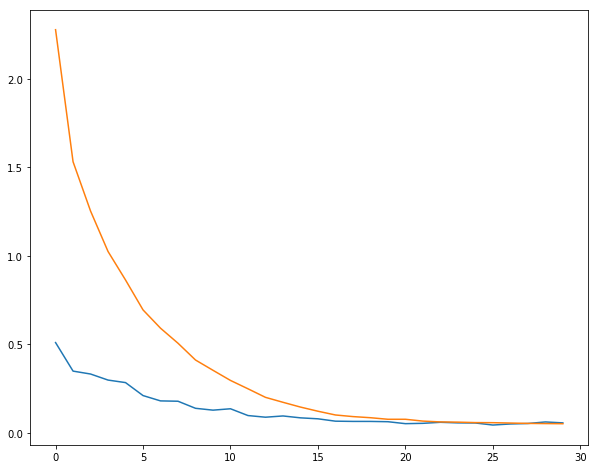

In [34]:
from neuralNetwork2 import *
from neuralNetwork3 import *
from weight_init import *
DEBUG_MODE = True
if DEBUG_MODE:
    NUM_HIDEN1 = 100
    NUM_HIDEN2 = 32
    DROPOUT = 0.5
    NUM_EPOCH = 30000

use_gpu = torch.cuda.is_available()
print("use gpu:",use_gpu)
model = neuralNetwork2(num_input,NUM_HIDEN1,1,DROPOUT)
model.apply(weight_init)
# try:
#     model.load_state_dict(torch.load('./model/neuralNetwork2.pth'))
# except:
#     pass
if use_gpu:
    model = model.cuda()

# 定义loss和优化函数
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 开始训练
losses_train  = []
losses_test = []


for epoch in range(NUM_EPOCH):
    model.train()
    for i,data in enumerate(train_loader):
        (X_batch, y_batch) = data["traindata"],data['label']
        if use_gpu:
            X_batch =X_batch.cuda()      
            y_batch =y_batch.cuda()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 1000 == 0:
        model.eval()
        with torch.no_grad():
            if use_gpu:
                x_test = x_test.cuda()
                y_test = y_test.cuda()
            predict = model(x_test)
            loss_test = criterion(predict, y_test)
        print(f'step:[{epoch+1}], train loss: {loss.item():.6f}, test loss: {loss_test.item():.6f}')
        losses_train.append(loss.item())
        losses_test.append(loss_test.item())

plt.figure(figsize = (10,8))
plt.plot(losses_train,label = "train loss")
plt.plot(losses_test,label = "teset loss")
plt.show()
torch.save(model.state_dict(), './model/neuralNetwork2.pth')

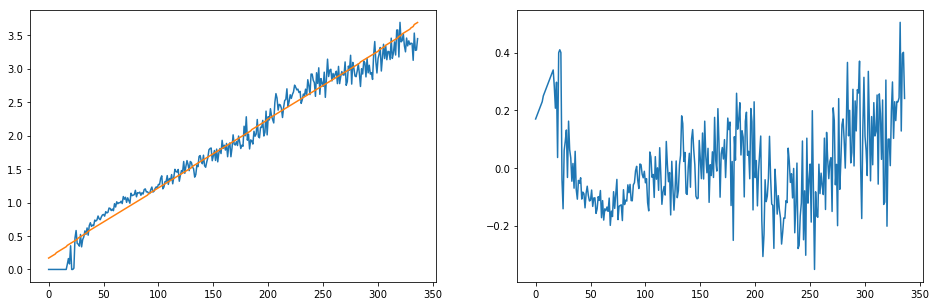

In [35]:
model.eval()
with torch.no_grad():
    x_train = x_train.cuda()
    predict = model(x_train)
predict = predict.cpu()
plt.close("all")
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(predict)
plt.plot(y_train)
plt.subplot(122)
plt.plot((y_train-predict))
# a = train_df["temperature"].values
# plt.plot(a[:350]-0.5)
plt.show()

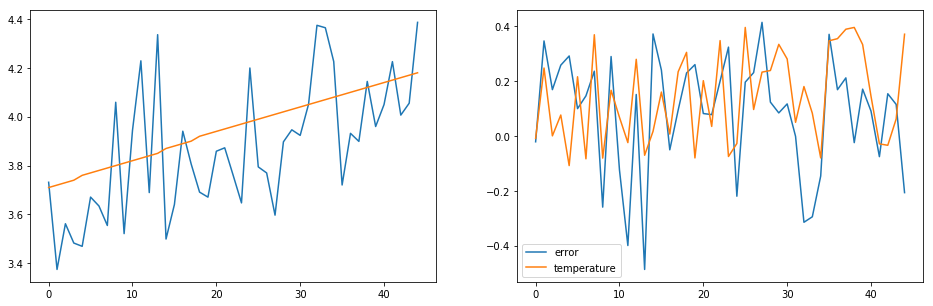

In [36]:
model.eval()
with torch.no_grad():
    x_test = x_test.cuda()
    predict = model(x_test)
predict = predict.cpu()
y_test = y_test.cpu()
x_test = x_test.cpu()
plt.close("all")
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(predict)
plt.plot(y_test)
plt.subplot(122)
plt.plot((y_test-predict),label = "error")
a = train_df["temperature"].values
plt.plot(a[-45:]-0.5,label = "temperature")
# plt.plot(x_test[:,-1]-0.5,label = "temperature")
plt.legend()
plt.show()